# `CNModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+6.ge3576a9.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]
Upper state quantum numbers: ['1 0 1 1', '1 0 

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

12CN-1 550
12CN-2 300


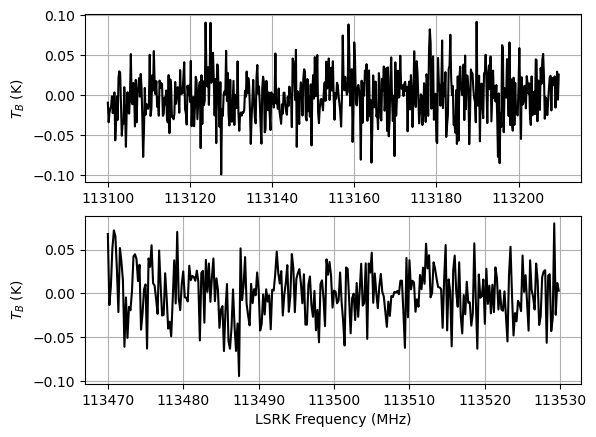

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, dummy_data["12CN-1"].brightness, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, dummy_data["12CN-2"].brightness, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.

Transition 113144.19 is constraining upper state 0 from lower state 1
Transition 113191.325 is constraining upper state 2 from lower state 1
Transition 113490.985 is constraining upper state 4 from lower state 1
Transition 113508.934 is constraining upper state 1 from lower state 1
Transition 113520.4215 is constraining upper state 3 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]
 [3.98107171 5.01187234 6.30957344]]

tau:
[[0.08329158 0.04671024 0.0102

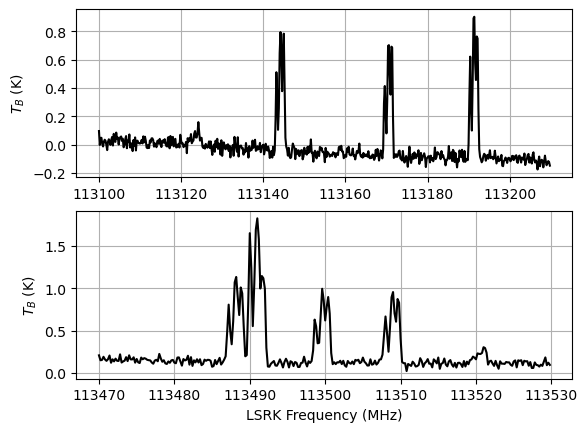

In [60]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.25, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE+CTEX model
    assume_CTEX = True, # assume CTEX
    prior_log10_inv_boltz_factor = 5.0, # ignored for this LTE+CTEX model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0": [13.8, 13.6, 13.0],
    "log10_Tkin": [0.6, 0.7, 0.8],
    "fwhm_nonthermal": [1.0, 1.5, 1.0],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau = model.model.tau.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
TR = model.model.TR.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total, "TR": TR}

print()
print("Tex:")
print(Tex)

print()
print("tau:")
print(tau)

print()
print("tau_total:")
print(tau_total)

print()
print("TR:")
print(TR)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [61]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

12CN-1 550
12CN-2 300


## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [62]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.25, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE+CTEX model
    assume_CTEX = True, # assume CTEX
    prior_log10_inv_boltz_factor = 5.0, # ignored for this LTE+CTEX model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 0 from lower state 1
Transition 113191.325 is constraining upper state 2 from lower state 1
Transition 113490.985 is constraining upper state 4 from lower state 1
Transition 113508.934 is constraining upper state 1 from lower state 1
Transition 113520.4215 is constraining upper state 3 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


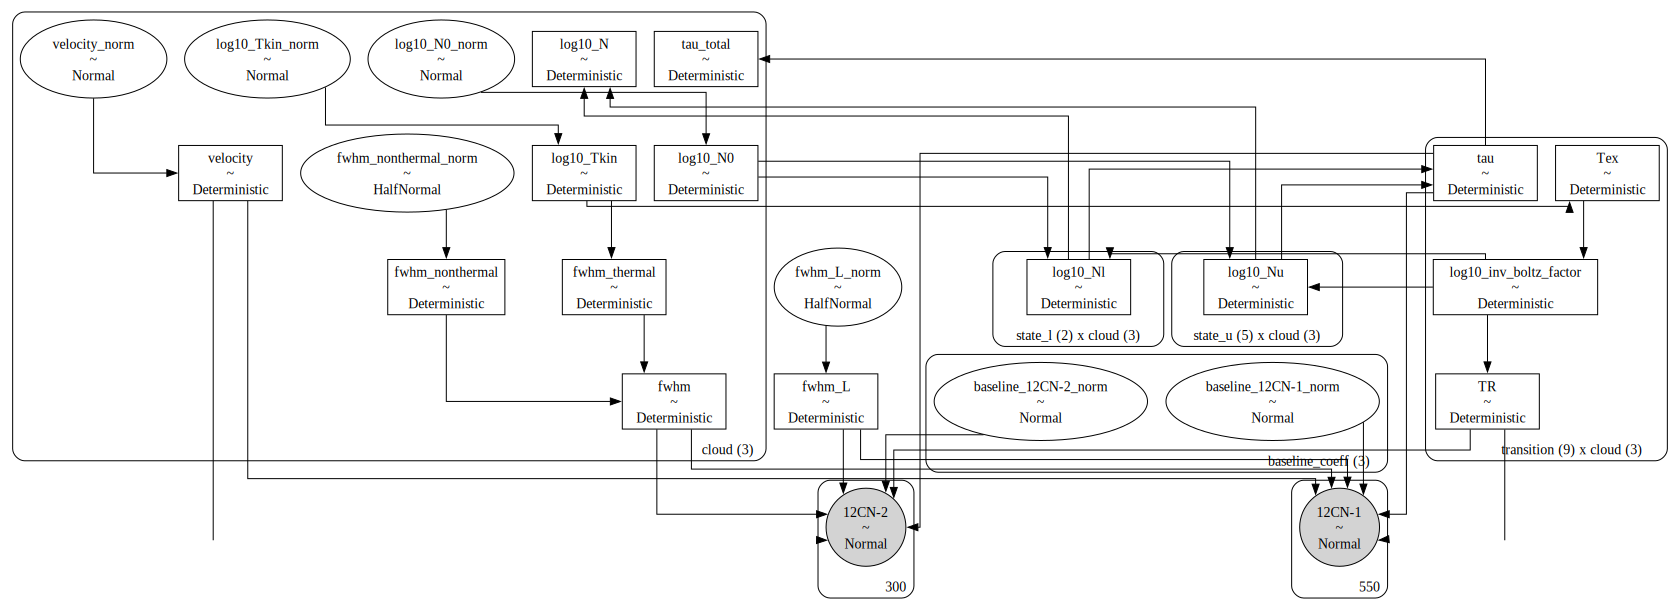

In [63]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [64]:
# model string representation
print(model.model.str_repr())

  baseline_12CN-1_norm ~ Normal(0, <constant>)
  baseline_12CN-2_norm ~ Normal(0, <constant>)
         velocity_norm ~ Normal(0, 1)
       log10_Tkin_norm ~ Normal(0, 1)
  fwhm_nonthermal_norm ~ HalfNormal(0, 1)
           fwhm_L_norm ~ HalfNormal(0, 1)
         log10_N0_norm ~ Normal(0, 1)
              velocity ~ Deterministic(f(velocity_norm))
            log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
          fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
       fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                  fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
                fwhm_L ~ Deterministic(f(fwhm_L_norm))
              log10_N0 ~ Deterministic(f(log10_N0_norm))
                   Tex ~ Deterministic(f(log10_Tkin_norm))
log10_inv_boltz_factor ~ Deterministic(f(log10_Tkin_norm))
              log10_Nl ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
              log10_Nu ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
          

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, velocity_norm]


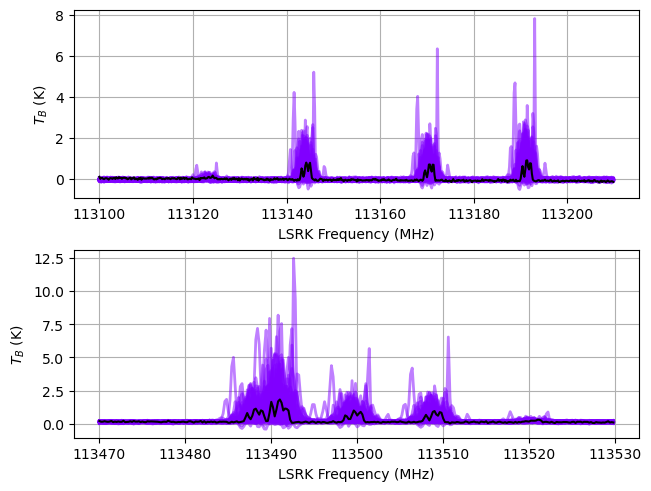

In [65]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

We can also check how our choice of priors affects the deterministic quantities, like excitation temperature and Boltzmann factor.

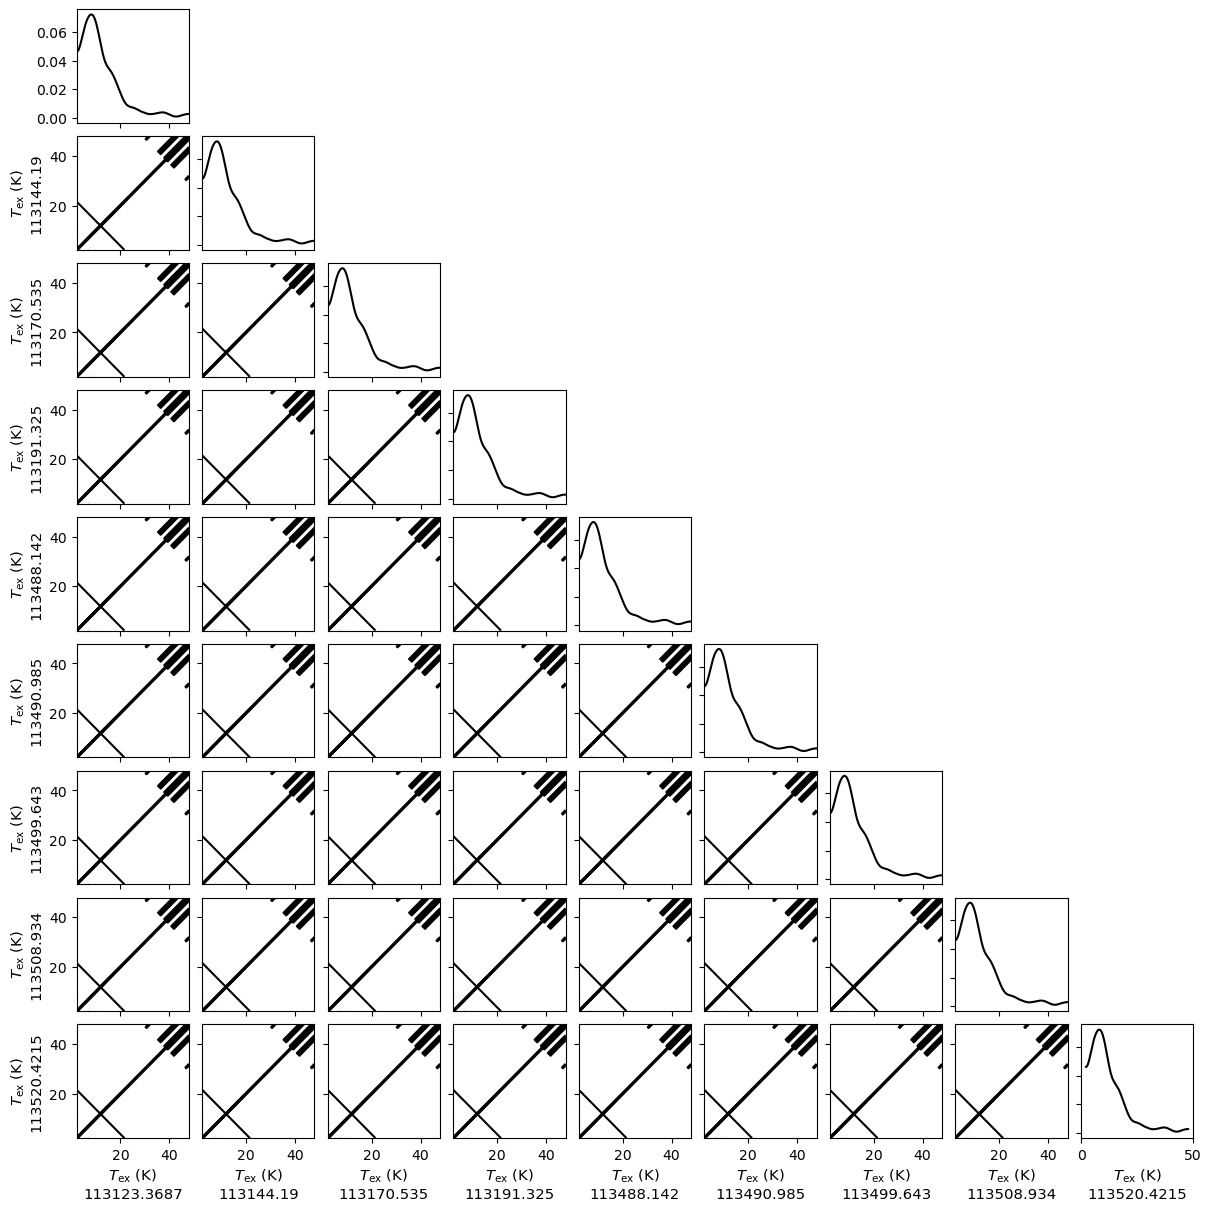

In [12]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    prior.prior, # samples
    ['Tex'], # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.set_size_inches(12, 12)

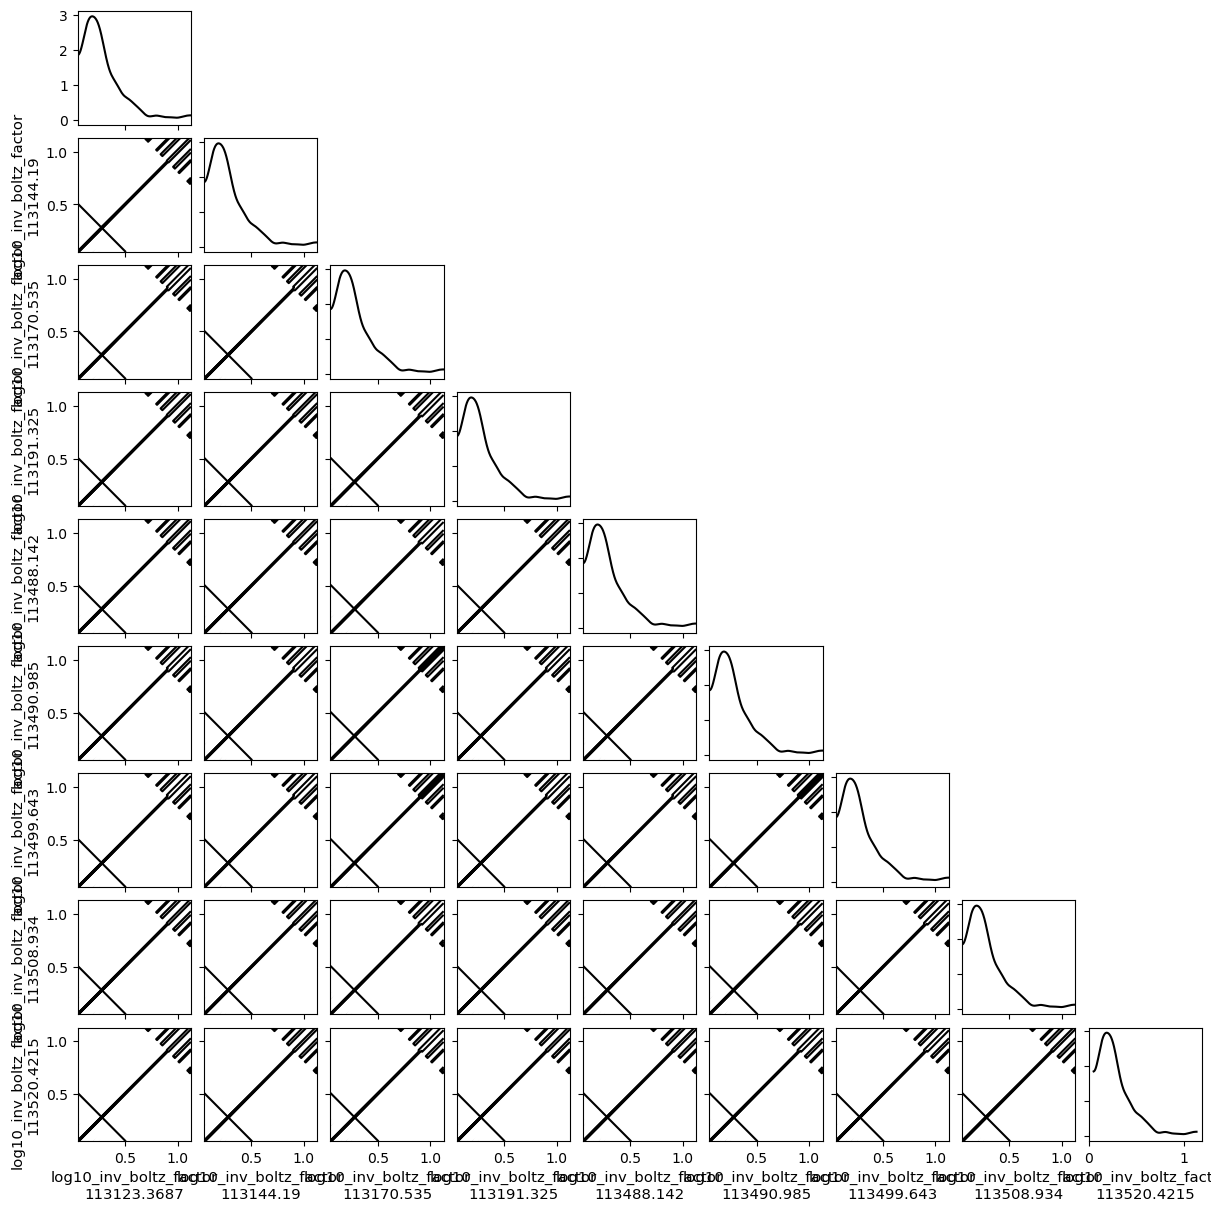

In [13]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    prior.prior, # samples
    ['log10_inv_boltz_factor'], # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.set_size_inches(12, 12)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [66]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 868.16


Output()

Runtime: 1.06 minutes


In [67]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -2.006  0.010  -2.025   -1.988      0.000    0.000   
velocity[1]              -0.010  0.008  -0.025    0.006      0.000    0.000   
velocity[2]               2.501  0.008   2.487    2.515      0.000    0.000   
log10_Tkin[0]             0.599  0.001   0.597    0.602      0.000    0.000   
log10_Tkin[1]             0.708  0.002   0.705    0.711      0.000    0.000   
log10_Tkin[2]             0.813  0.004   0.806    0.820      0.000    0.000   
fwhm_thermal[0]           0.084  0.000   0.083    0.084      0.000    0.000   
fwhm_thermal[1]           0.095  0.000   0.094    0.095      0.000    0.000   
fwhm_thermal[2]           0.107  0.000   0.106    0.108      0.000    0.000   
fwhm_nonthermal[0]        0.988  0.020   0.951    1.024      0.001    0.000   
fwhm_nonthermal[1]        1.503  0.020   1.468    1.541      0.001    0.000   
fwhm_nonthermal[2]        0.982  0.021   0.940    1.018      0.001    0.000   
fwhm[0]                   0.992  0.020   0.954    1.028      0.001    0.000   
fwhm[1]                   1.506  0.020   1.472    1.544      0.001    0.000   
fwhm[2]                   0.988  0.021   0.946    1.023      0.001    0.000   
log10_N0[0]              13.827  0.010  13.811   13.845      0.000    0.000   
log10_N0[1]              13.570  0.005  13.561   13.579      0.000    0.000   
log10_N0[2]              12.985  0.006  12.974   12.996      0.000    0.000   
log10_N[0]               14.250  0.010  14.233   14.267      0.000    0.000   
log10_N[1]               14.055  0.005  14.046   14.064      0.000    0.000   
log10_N[2]               13.523  0.006  13.511   13.534      0.000    0.000   
tau_total[0]              7.364  0.161   7.088    7.663      0.005    0.004   
tau_total[1]              3.580  0.041   3.505    3.658      0.001    0.001   
tau_total[2]              0.806  0.012   0.783    0.828      0.000    0.000   
fwhm_L                    0.009  0.010   0.001    0.026      0.000    0.000   
baseline_12CN-1_norm[0]  -0.241  0.044  -0.326   -0.163      0.001    0.001   
baseline_12CN-1_norm[1]  -4.819  0.164  -5.131   -4.521      0.005    0.004   
baseline_12CN-1_norm[2]   2.184  0.707   0.740    3.366      0.023    0.016   
baseline_12CN-2_norm[0]  -0.497  0.066  -0.632   -0.387      0.002    0.002   
baseline_12CN-2_norm[1]  -1.408  0.225  -1.818   -0.996      0.007    0.005   
baseline_12CN-2_norm[2]   1.577  0.809   0.069    3.034      0.026    0.018   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                 948.0    1035.0    NaN  
velocity[1]                 842.0     842.0    NaN  
velocity[2]                1020.0     842.0    NaN  
log10_Tkin[0]               799.0     787.0    NaN  
log10_Tkin[1]               679.0     944.0    NaN  
log10_Tkin[2]               850.0     884.0    NaN  
fwhm_thermal[0]             799.0     787.0    NaN  
fwhm_thermal[1]             679.0     944.0    NaN  
fwhm_thermal[2]             850.0     884.0    NaN  
fwhm_nonthermal[0]         1015.0     905.0    NaN  
fwhm_nonthermal[1]         1000.0     820.0    NaN  
fwhm_nonthermal[2]         1009.0     981.0    NaN  
fwhm[0]                    1015.0     905.0    NaN  
fwhm[1]                    1000.0     820.0    NaN  
fwhm[2]                    1009.0     981.0    NaN  
log10_N0[0]                1024.0     889.0    NaN  
log10_N0[1]                1026.0     943.0    NaN  
log10_N0[2]                1049.0     979.0    NaN  
log10_N[0]                  993.0     872.0    NaN  
log10_N[1]                 1052.0     944.0    NaN  
log10_N[2]                 1056.0    1033.0    NaN  
tau_total[0]               1037.0     900.0    NaN  
tau_total[1]                991.0     845.0    NaN  
tau_total[2]                928.0     842.0    NaN  
fwhm_L                     1093.0     847.0    NaN  
baseline_12CN-1_norm[0]     981.0     921.0    NaN  
baseline_12CN-1_norm[1]     997.0     881.0    NaN  
baseline_12CN-

Sampling: [12CN-1, 12CN-2]


Output()

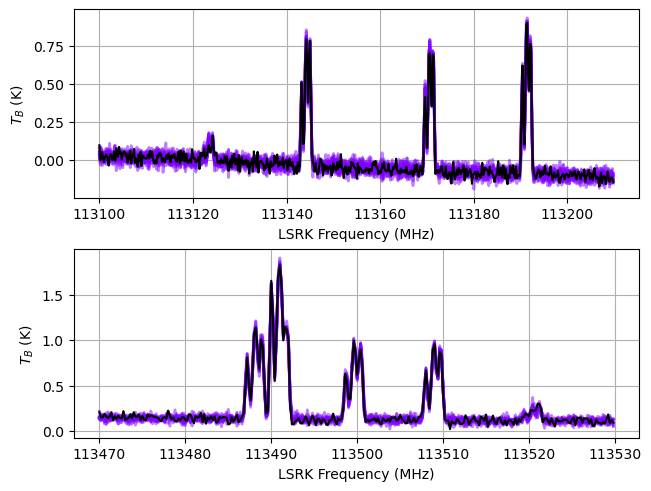

In [68]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [69]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.05, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 868.16
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N0_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 385 seconds.


Adding log-likelihood to trace


Output()

Runtime: 8.05 minutes


In [70]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [71]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -2.004  0.010  -2.023   -1.986      0.000    0.000   
velocity[1]              -0.005  0.009  -0.022    0.012      0.000    0.000   
velocity[2]               2.502  0.008   2.488    2.517      0.000    0.000   
log10_Tkin[0]             0.597  0.003   0.593    0.602      0.000    0.000   
log10_Tkin[1]             0.708  0.005   0.700    0.718      0.000    0.000   
log10_Tkin[2]             0.831  0.032   0.776    0.893      0.000    0.000   
fwhm_thermal[0]           0.083  0.000   0.083    0.084      0.000    0.000   
fwhm_thermal[1]           0.095  0.001   0.094    0.096      0.000    0.000   
fwhm_thermal[2]           0.109  0.004   0.102    0.117      0.000    0.000   
fwhm_nonthermal[0]        0.986  0.022   0.945    1.026      0.000    0.000   
fwhm_nonthermal[1]        1.502  0.024   1.457    1.548      0.000    0.000   
fwhm_nonthermal[2]        0.980  0.022   0.939    1.022      0.000    0.000   
fwhm[0]                   0.990  0.022   0.949    1.030      0.000    0.000   
fwhm[1]                   1.505  0.024   1.460    1.551      0.000    0.000   
fwhm[2]                   0.987  0.022   0.945    1.028      0.000    0.000   
log10_N0[0]              13.827  0.019  13.791   13.863      0.000    0.000   
log10_N0[1]              13.570  0.014  13.546   13.597      0.000    0.000   
log10_N0[2]              12.966  0.044  12.883   13.046      0.001    0.000   
log10_N[0]               14.248  0.018  14.214   14.281      0.000    0.000   
log10_N[1]               14.055  0.011  14.034   14.076      0.000    0.000   
log10_N[2]               13.511  0.029  13.453   13.564      0.000    0.000   
tau_total[0]              7.374  0.347   6.751    8.039      0.004    0.003   
tau_total[1]              3.582  0.132   3.339    3.836      0.002    0.001   
tau_total[2]              0.757  0.109   0.547    0.960      0.001    0.001   
fwhm_L                    0.008  0.007   0.000    0.021      0.000    0.000   
baseline_12CN-1_norm[0]  -0.245  0.053  -0.345   -0.144      0.001    0.000   
baseline_12CN-1_norm[1]  -4.834  0.144  -5.098   -4.564      0.001    0.001   
baseline_12CN-1_norm[2]   2.166  0.793   0.675    3.665      0.009    0.006   
baseline_12CN-2_norm[0]  -0.520  0.072  -0.654   -0.388      0.001    0.001   
baseline_12CN-2_norm[1]  -1.403  0.199  -1.768   -1.013      0.002    0.001   
baseline_12CN-2_norm[2]   1.481  0.886  -0.194    3.119      0.009    0.007   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                7795.0    6368.0    1.0  
velocity[1]                8313.0    6008.0    1.0  
velocity[2]               11676.0    5557.0    1.0  
log10_Tkin[0]              5924.0    6444.0    1.0  
log10_Tkin[1]              6239.0    5797.0    1.0  
log10_Tkin[2]              5390.0    4214.0    1.0  
fwhm_thermal[0]            5924.0    6444.0    1.0  
fwhm_thermal[1]            6239.0    5797.0    1.0  
fwhm_thermal[2]            5390.0    4214.0    1.0  
fwhm_nonthermal[0]         7078.0    5994.0    1.0  
fwhm_nonthermal[1]         7014.0    6200.0    1.0  
fwhm_nonthermal[2]         9017.0    6577.0    1.0  
fwhm[0]                    7075.0    5994.0    1.0  
fwhm[1]                    7012.0    6200.0    1.0  
fwhm[2]                    8858.0    6549.0    1.0  
log10_N0[0]                6246.0    6378.0    1.0  
log10_N0[1]                6176.0    5649.0    1.0  
log10_N0[2]                5475.0    4382.0    1.0  
log10_N[0]                 6323.0    6370.0    1.0  
log10_N[1]                 6233.0    6030.0    1.0  
log10_N[2]                 5554.0    4647.0    1.0  
tau_total[0]               6201.0    6353.0    1.0  
tau_total[1]               6158.0    5522.0    1.0  
tau_total[2]               5441.0    4260.0    1.0  
fwhm_L                     7032.0    3573.0    1.0  
baseline_12CN-1_norm[0]    8683.0    6106.0    1.0  
baseline_12CN-1_norm[1]   13116.0    5737.0    1.0  
baseline_12CN-

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [12CN-1, 12CN-2]


Output()

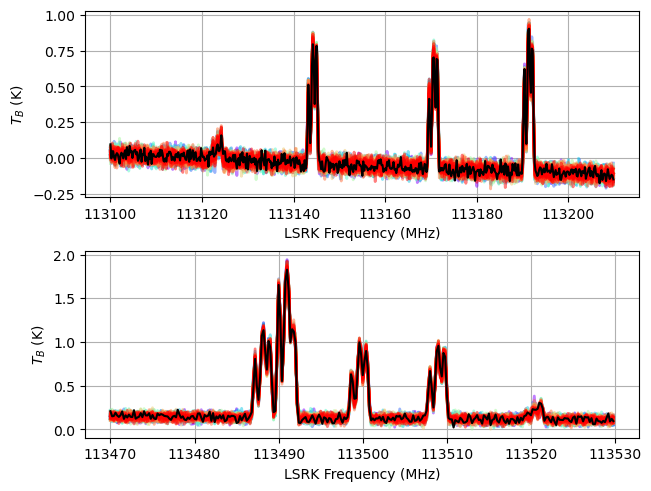

In [72]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

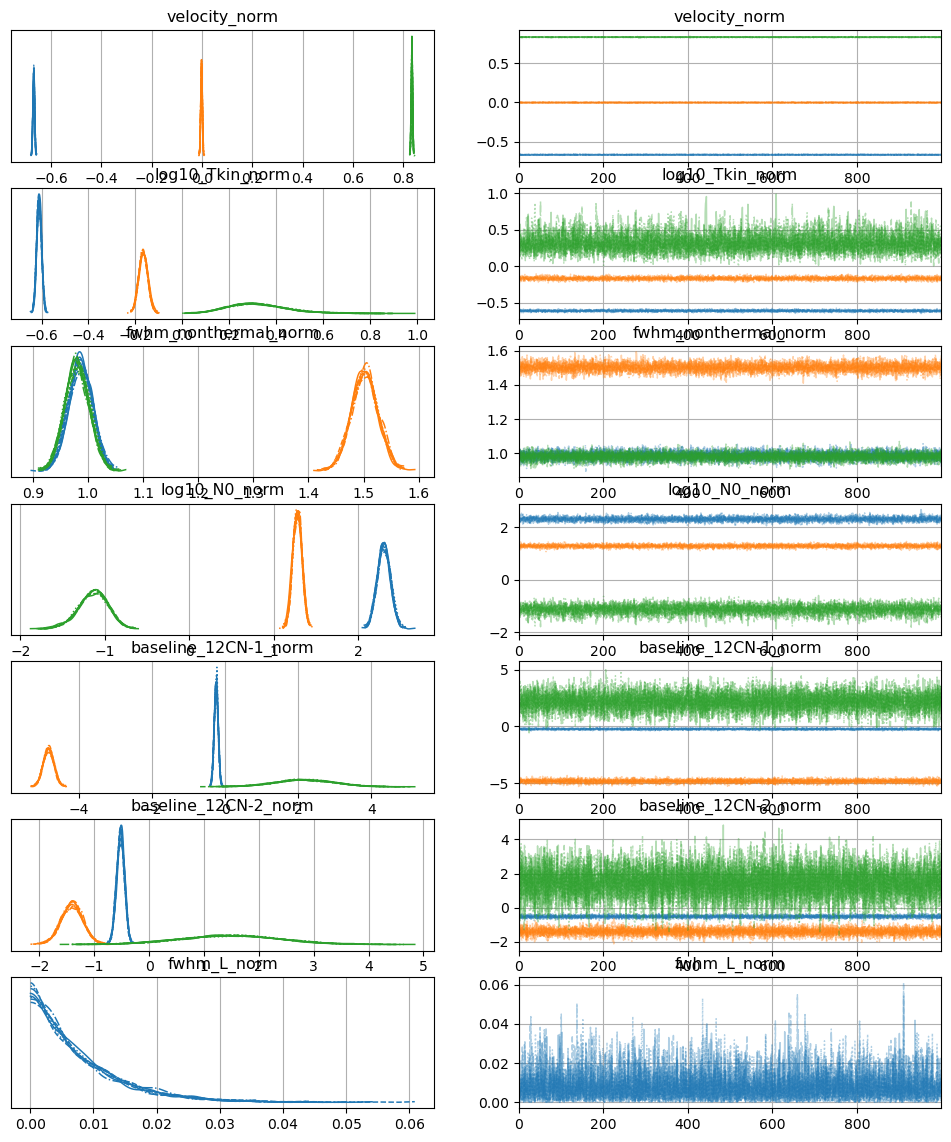

In [73]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

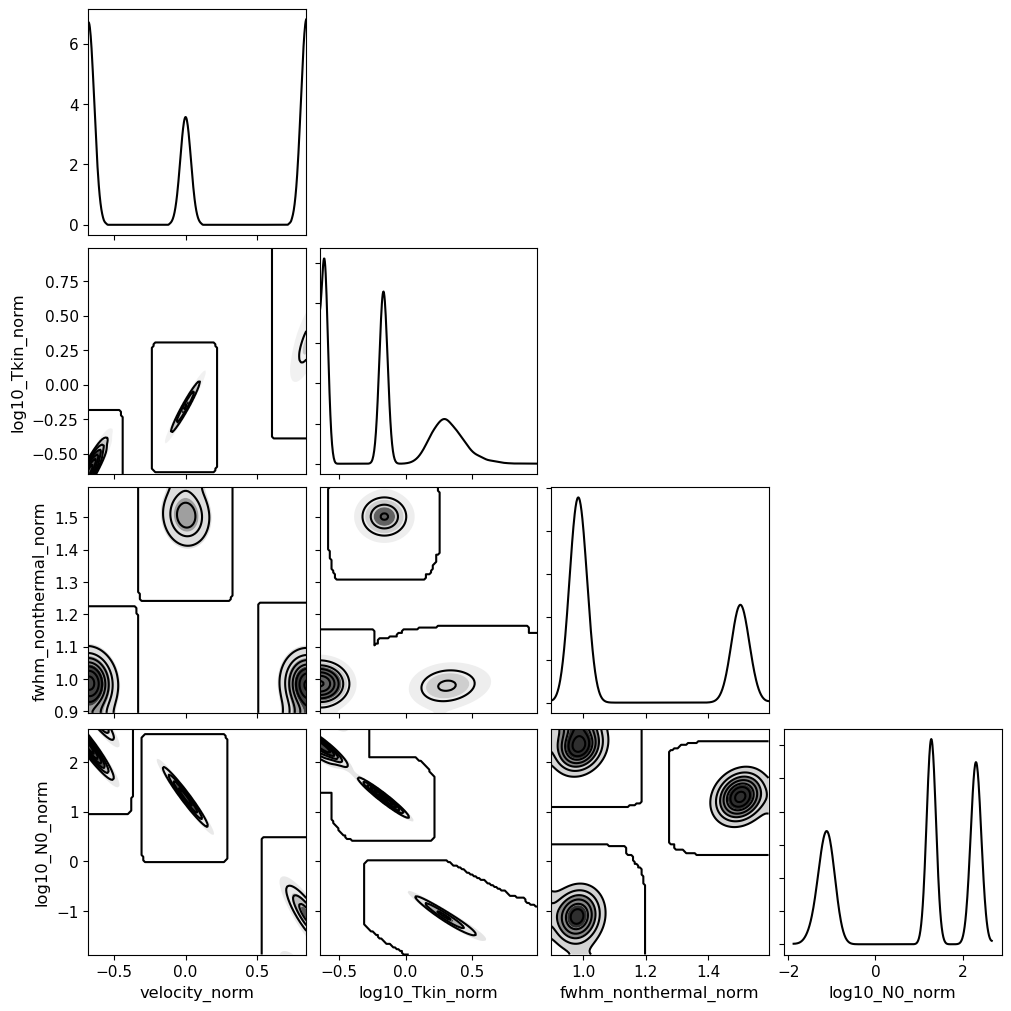

In [74]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

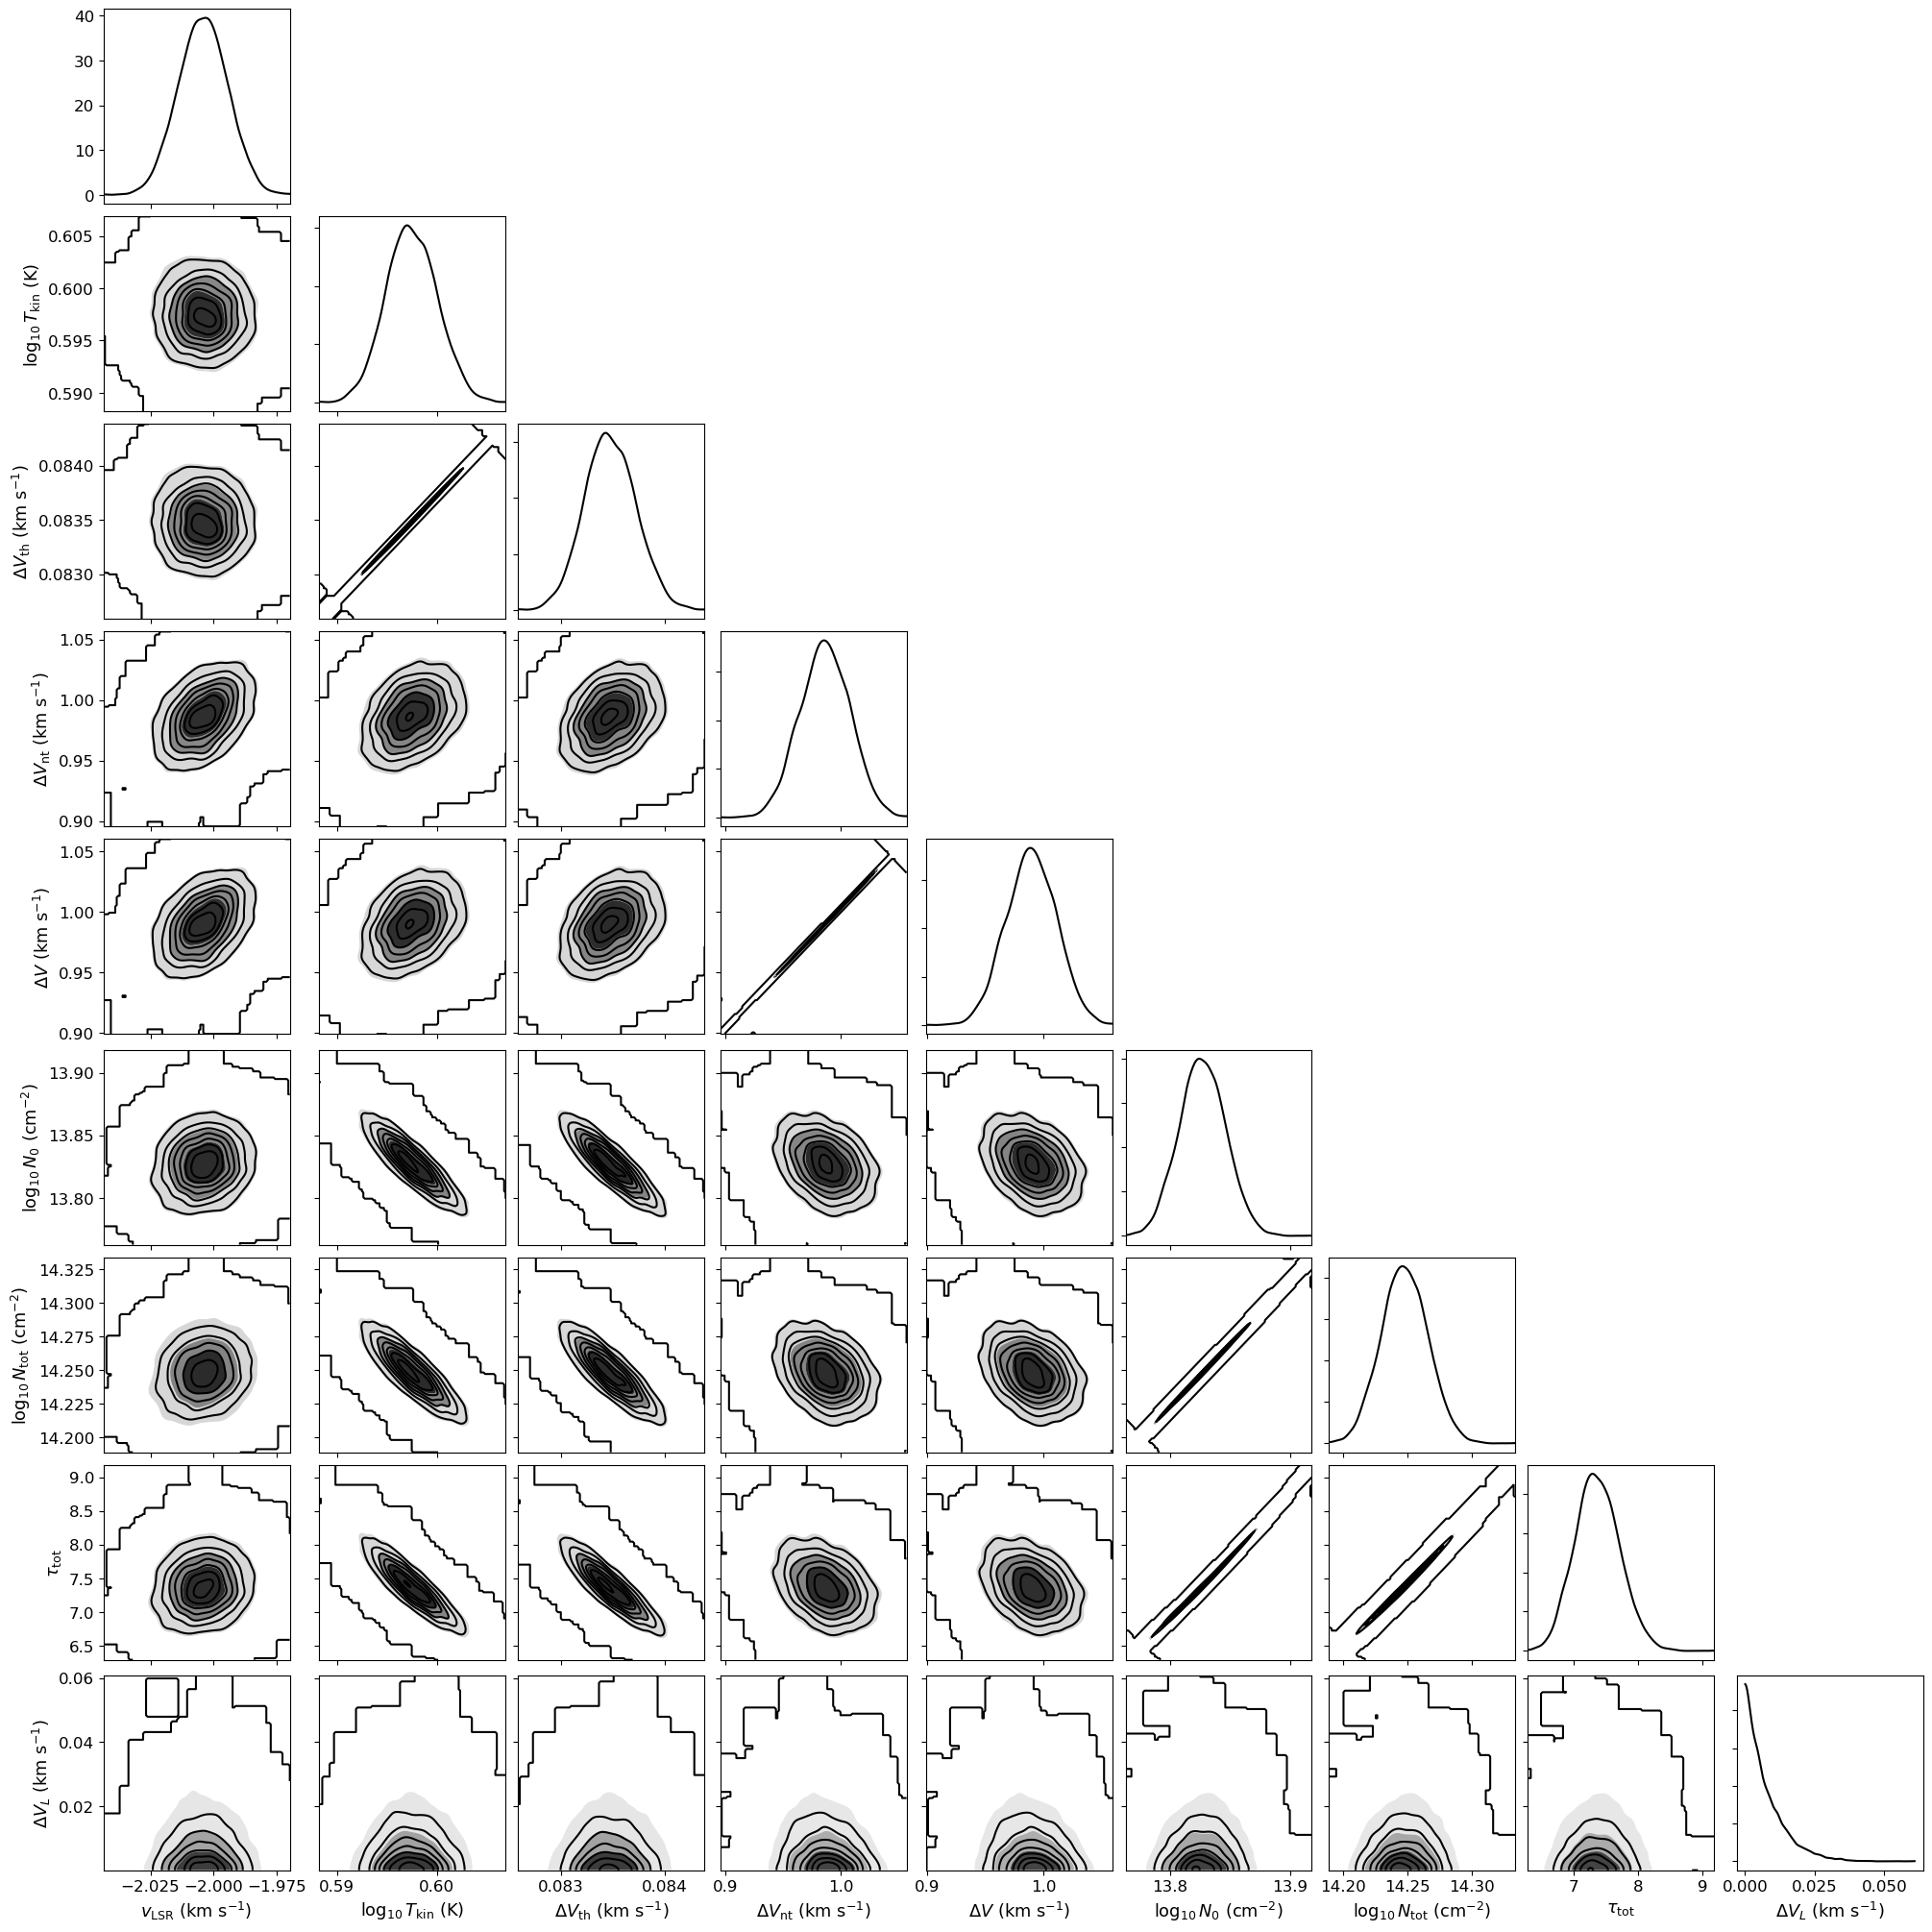

In [75]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

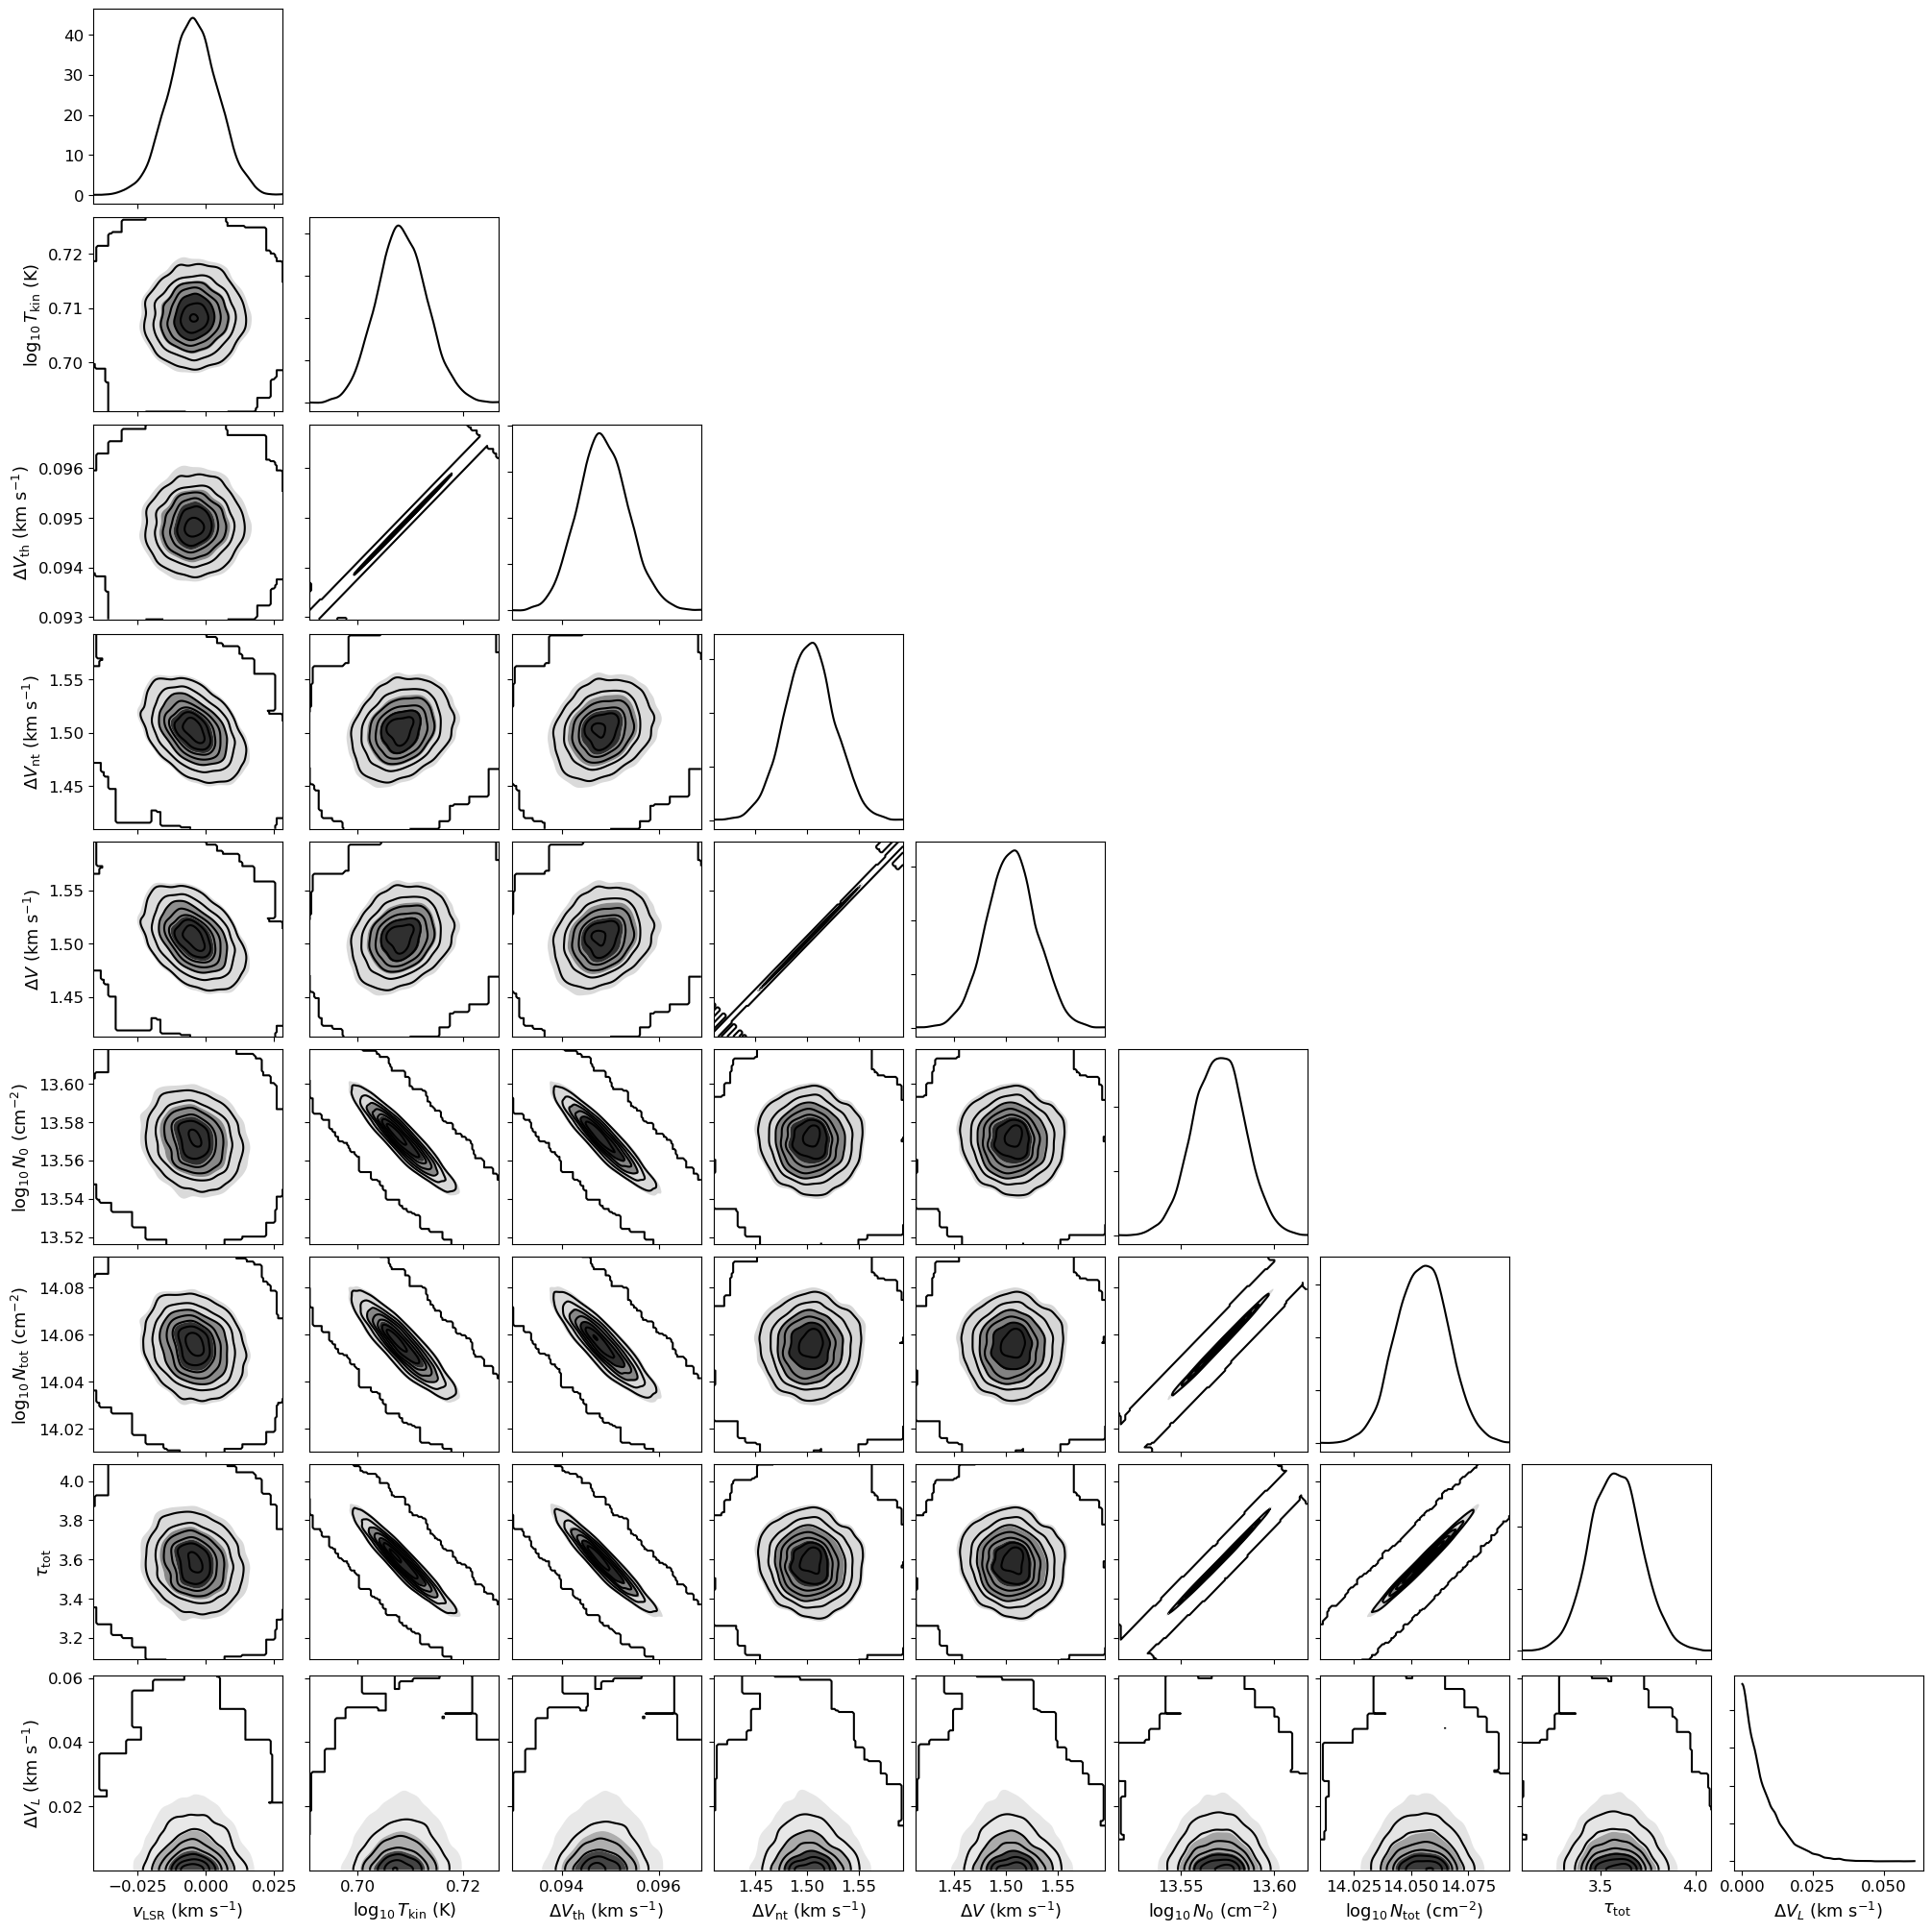

In [76]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

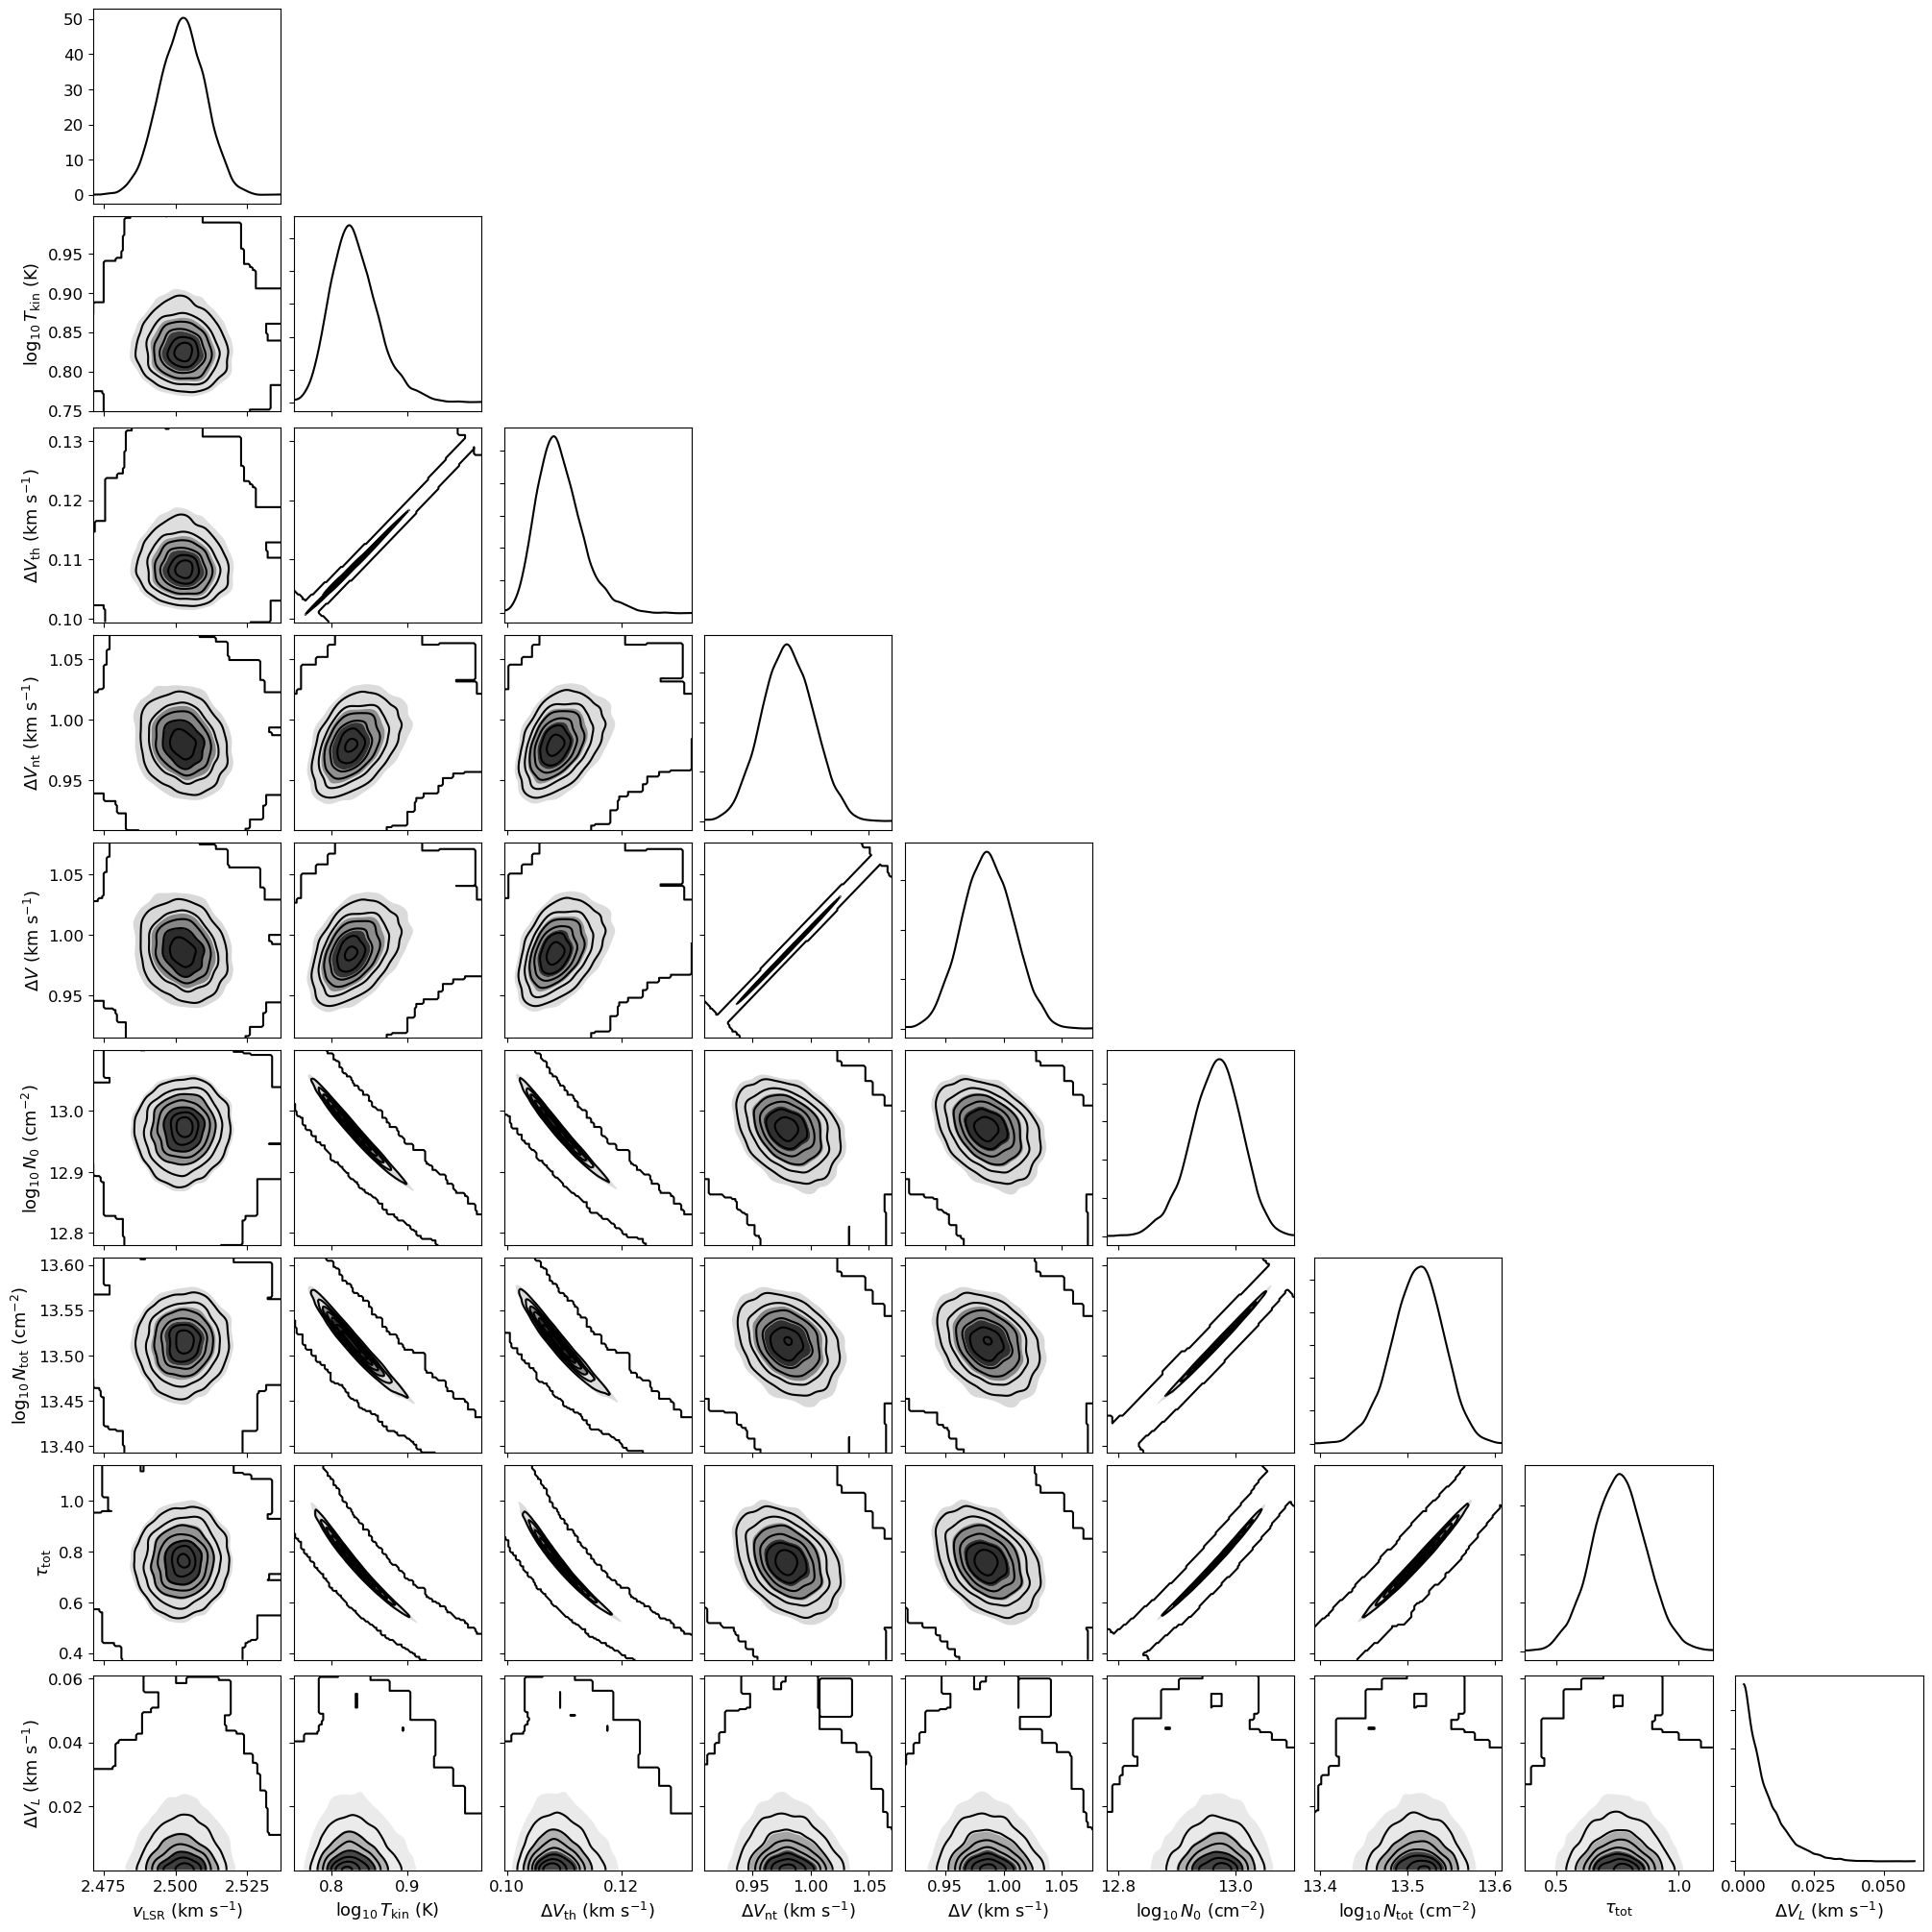

In [77]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [78]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3419.024272620059


mean     sd  hdi_16%  hdi_84%
velocity[0]                             -2.004  0.010   -2.013   -1.994
velocity[1]                             -0.005  0.009   -0.013    0.005
velocity[2]                              2.502  0.008    2.494    2.510
log10_Tkin[0]                            0.597  0.003    0.595    0.600
log10_Tkin[1]                            0.708  0.005    0.703    0.713
log10_Tkin[2]                            0.831  0.032    0.795    0.854
fwhm_thermal[0]                          0.083  0.000    0.083    0.084
fwhm_thermal[1]                          0.095  0.001    0.094    0.095
fwhm_thermal[2]                          0.109  0.004    0.105    0.112
fwhm_nonthermal[0]                       0.986  0.022    0.965    1.008
fwhm_nonthermal[1]                       1.502  0.024    1.477    1.524
fwhm_nonthermal[2]                       0.980  0.022    0.958    1.002
fwhm[0]                                  0.990  0.022    0.968    1.012
fwhm[1]                                  1.505  0.024    1.480    1.527
fwhm[2]                                  0.987  0.022    0.966    1.010
log10_N0[0]                             13.827  0.019   13.809   13.847
log10_N0[1]                             13.570  0.014   13.557   13.584
log10_N0[2]                             12.966  0.044   12.926   13.011
Tex[113123.3687, 0]                      3.958  0.023    3.934    3.980
Tex[113123.3687, 1]                      5.110  0.056    5.051    5.162
Tex[113123.3687, 2]                      6.791  0.508    6.192    7.104
Tex[113144.19, 0]                        3.958  0.023    3.934    3.980
Tex[113144.19, 1]                        5.110  0.056    5.051    5.162
Tex[113144.19, 2]                        6.791  0.508    6.192    7.104
Tex[113170.535, 0]                       3.958  0.023    3.934    3.980
Tex[113170.535, 1]                       5.110  0.056    5.051    5.162
Tex[113170.535, 2]                       6.791  0.508    6.192    7.104
Tex[113191.325, 0]                       3.958  0.023    3.934    3.980
Tex[113191.325, 1]                       5.110  0.056    5.051    5.162
Tex[113191.325, 2]                       6.791  0.508    6.192    7.104
Tex[113488.142, 0]                       3.958  0.023    3.934    3.980
Tex[113488.142, 1]                       5.110  0.056    5.051    5.162
Tex[113488.142, 2]                       6.791  0.508    6.192    7.104
Tex[113490.985, 0]                       3.958  0.023    3.934    3.980
Tex[113490.985, 1]                       5.110  0.056    5.051    5.162
Tex[113490.985, 2]                       6.791  0.508    6.192    7.104
Tex[113499.643, 0]                       3.958  0.023    3.934    3.980
Tex[113499.643, 1]                       5.110  0.056    5.051    5.162
Tex[113499.643, 2]                       6.791  0.508    6.192    7.104
Tex[113508.934, 0]                       3.958  0.023    3.934    3.980
Tex[113508.934, 1]                       5.110  0.056    5.051    5.162
Tex[113508.934, 2]                       6.791  0.508    6.192    7.104
Tex[113520.4215, 0]                      3.958  0.023    3.934    3.980
Tex[113520.4215, 1]                      5.110  0.056    5.051    5.162
Tex[113520.4215, 2]                      6.791  0.508    6.192    7.104
log10_inv_boltz_factor[113123.3687, 0]   0.596  0.004    0.592    0.599
log10_inv_boltz_factor[113123.3687, 1]   0.461  0.005    0.457    0.467
log10_inv_boltz_factor[113123.3687, 2]   0.349  0.025    0.328    0.377
log10_inv_boltz_factor[113144.19, 0]     0.596  0.004    0.593    0.599
log10_inv_boltz_factor[113144.19, 1]     0.462  0.005    0.457    0.467
log10_inv_boltz_factor[113144.19, 2]     0.349  0.025    0.328    0.377
log10_inv_boltz_factor[113170.535, 0]    0.596  0.004    0.593    0.600
log10_inv_boltz_factor[113170.535, 1]    0.462  0.005    0.457    0.467
log10_inv_boltz_factor[113170.535, 2]    0.349  0.025    0.328    0.377
log10_inv_boltz_factor[113191.325, 0]    0.596  0.004    0.593    0.600
log10_inv_

In [79]:
print(sim_params)
print(derived_params)

{'log10_N0': [13.8, 13.6, 13.0], 'log10_Tkin': [0.6, 0.7, 0.8], 'fwhm_nonthermal': [1.0, 1.5, 1.0], 'velocity': [-2.0, 0.0, 2.5], 'fwhm_L': 0.0, 'baseline_12CN-1_norm': [-2.0, -5.0, 8.0], 'baseline_12CN-2_norm': [4.0, -2.0, 5.0]}
{'log10_N': array([14.22272541, 14.07989297, 13.5314017 ]), 'tau_total': array([6.90663673, 3.8739077 , 0.84897928]), 'TR': array([[1.86520154, 2.77809747, 3.97960636],
       [1.86491585, 2.77777149, 3.9792466 ],
       [1.86455441, 2.77735907, 3.97879143],
       [1.86426923, 2.77703365, 3.97843226],
       [1.86020143, 2.77239079, 3.97330714],
       [1.8601625 , 2.77234635, 3.97325807],
       [1.86004396, 2.77221102, 3.97310865],
       [1.85991675, 2.77206579, 3.97294831],
       [1.85975948, 2.77188624, 3.97275007]])}
